In [1]:
from finlab.data import Data
data = Data()

D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# 條件一：公司的市值

In [2]:
# 先拿出計算市值需要用到的財務數據

股本 = data.get('股本合計', 1)
price = data.get('收盤價', 100)

In [3]:

# ----------- #
# 找出當天股價  #
# ----------- #

# 新版（較簡單）：將頻率為「天」的股價，reindex 成每「季」
# method='fill'是說，假如公佈財報那天沒有股價，則以時間往前最接近的那天為主。

當天股價 = price.reindex(股本.index, method='ffill').iloc[-1]

# 原本（較難）：當天股價 = price.loc[:股本.index[0]].iloc[-1]

# ----------- #
# 找出當天股本  #
# ----------- #

當天股本 = 股本.iloc[-1]

# -----------  #
# 計算市值      #
# -----------  #

# 市值 = 總股數 * 股價
#     = （股本 * 1000） / 10 * 股價

市值 = 當天股本 * 1000 / 10 * 當天股價
市值['1101']

nan

# 條件二：自由現金流

In [4]:
import pandas as pd

# 將每季累計的財務數據，轉換成單季
def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()
    
# 計算自由現金流 = 營業活動之淨現金流入 - 投資活動之淨現金流出
投資現金流 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 8))
營業現金流 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 8))
自由現金流 = (投資現金流 + 營業現金流).iloc[-4:].sum()
自由現金流.describe()

count    2.462000e+03
mean     8.658793e+05
std      1.263505e+07
min     -1.178851e+08
25%     -8.208450e+04
50%      0.000000e+00
75%      2.011375e+05
max      3.763265e+08
dtype: float64

# 條件三：股東權益報酬率

In [5]:
稅後淨利 = data.get('本期淨利（淨損）', 1)

# 修正：因為有些股東權益的名稱叫作「權益總計」有些叫作「權益總額」，所以要先將這兩個dataframe合併起來喔！
權益總計 = data.get('權益總計', 1)
權益總額 = data.get('權益總額', 1)

# 把它們合併起來（將「權益總計」為NaN的部分填上「權益總額」）
權益總計.fillna(權益總額, inplace=True)

股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
股東權益報酬率.describe()

count    1753.000000
mean        0.018414
std         0.088967
min        -2.076294
25%         0.004963
50%         0.023502
75%         0.042453
max         0.513252
Name: 2022-05-15 00:00:00, dtype: float64

# 條件四：營業利益成長率

In [6]:
# 影片中打錯了，這裡才是對的喔！
營業利益 = data.get('營業利益（損失）', 5)
營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
營業利益成長率.describe()

count     1708.000000
mean        14.021841
std        716.509396
min      -6484.905660
25%        -54.692829
50%         -1.865090
75%         47.636605
max      17728.571429
dtype: float64

# 條件五：市值營收比

In [7]:
%matplotlib inline
當月營收 = data.get('當月營收', 4) * 1000
當季營收 = 當月營收.iloc[-4:].sum() # 取近4個月營收總和，當作一季的月營收（4也可以改變）
市值營收比 = 市值 / 當季營收
市值營收比.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

# 結合上述五個條件選股

In [8]:
condition1 = (市值 < 10000000000)
condition2 = 自由現金流 > 0
condition3 = 股東權益報酬率 > 0
condition4 = 營業利益成長率 > 0
condition5 = 市值營收比 < 5

# 將條件做交集（&）
select_stock = condition1 & condition2 & condition3 & condition4 & condition5 

# 選出的股票
select_stock[select_stock]

Series([], dtype: bool)

# 綜合上述，優等生策略：mystrategy

In [9]:
import pandas as pd

def mystrategy(data):
    
    股本 = data.get('股本合計', 1)
    price = data.get('收盤價', 120)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5
    
    return select_stock[select_stock]


# 回測

2017-01-01 - 2017-03-02 報酬率: 8.19 % nstock 263
2017-03-02 - 2017-05-01 報酬率: 2.77 % nstock 256
2017-05-01 - 2017-06-30 報酬率: 2.86 % nstock 206
2017-06-30 - 2017-08-29 報酬率: 8.58 % nstock 180
2017-08-29 - 2017-10-28 報酬率: 4.21 % nstock 182
2017-10-28 - 2017-12-27 報酬率: 0.79 % nstock 184
2017-12-27 - 2018-02-25 報酬率: 0.57 % nstock 183
2018-02-25 - 2018-04-26 報酬率: 0.34 % nstock 177
2018-04-26 - 2018-06-25 報酬率: 5.42 % nstock 125
2018-06-25 - 2018-08-24 報酬率: -2.40 % nstock 108
2018-08-24 - 2018-10-23 報酬率: -10.19 % nstock 152
2018-10-23 - 2018-12-22 報酬率: 4.75 % nstock 150
2018-12-22 - 2019-02-20 報酬率: 8.45 % nstock 187
2019-02-20 - 2019-04-21 報酬率: 7.81 % nstock 187
2019-04-21 - 2019-06-20 報酬率: -1.80 % nstock 143
2019-06-20 - 2019-08-19 報酬率: 5.05 % nstock 159
2019-08-19 - 2019-10-18 報酬率: 2.56 % nstock 198
2019-10-18 - 2019-12-17 報酬率: 1.83 % nstock 196
2019-12-17 - 2020-02-15 報酬率: -2.51 % nstock 202
2020-02-15 - 2020-04-15 報酬率: -5.80 % nstock 194
2020-04-15 - 2020-06-14 報酬率: 12.03 % nstock 240
2020-0

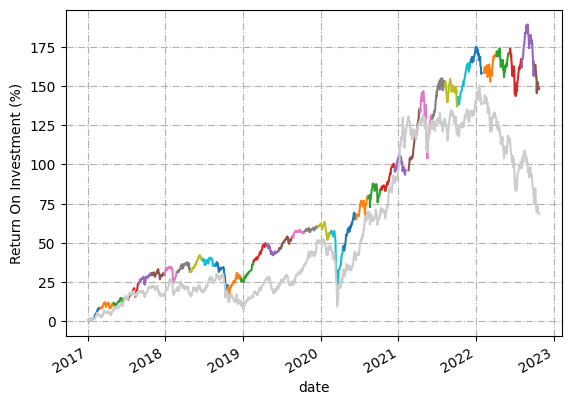

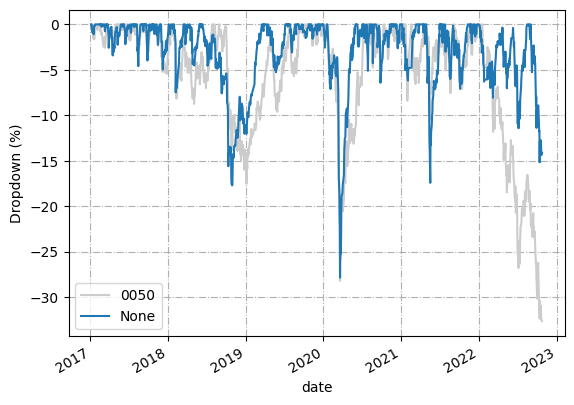

(2017-01-04    1.000000
 2017-01-05    1.005130
 2017-01-06    1.010805
 2017-01-09    1.006092
 2017-01-10    1.004282
                 ...   
 2022-10-18    2.524737
 2022-10-19    2.520313
 2022-10-20    2.495461
 2022-10-21    2.477829
 2022-10-24    2.485160
 Length: 1407, dtype: float64,
            buy_price  sell_price  lowest_price  highest_price   buy_date  \
 stock_id                                                                   
 1203       33.292051   34.745853     33.219361      35.400063 2017-01-04   
 1218       17.308871   17.366376     17.136358      17.998926 2017-01-04   
 1231       60.091537   59.809858     59.434286      61.124360 2017-01-04   
 1256      209.374440  230.395970    209.374440     237.963721 2017-01-04   
 1259       96.175493  102.314354     95.919707     102.314354 2017-01-04   
 ...              ...         ...           ...            ...        ...   
 8923       38.920831   43.368926     38.920831      43.368926 2022-10-04   
 8928       

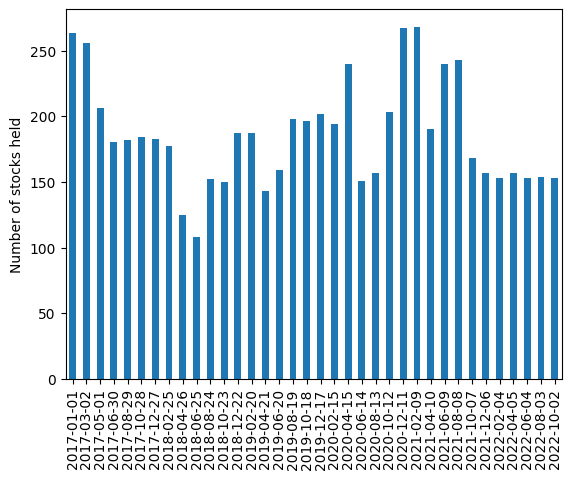

In [10]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime

%matplotlib inline
data = Data()
backtest(datetime.date(2017,1,1), datetime.date(2022,10,24), 60, mystrategy, data)